# Overview

Shor's algorithm is used for finding the prime factors of an integer. In this notebook we will denote $N$ as the integer to-be-factored, and $p$,$q$ as the prime factors of $N$ (i.e., $N = p \cdot q$).

The pseudocode for Shor's algorithm is outlined below.

$\newcommand{\if}[1]{{\textbf{if }{#1}\textbf{ then:}}}$
$\newcommand{\else}{{\textbf{else:}}}$

---
**Algorithm Shor**

**Input:** An integer $N$

**Output:** $p,q$ such that $N=p \cdot q$

**begin**

```
Choose a random integer 1 < a < N
b := gcd(a,N)
if b != 1:
    b factors N so return (p, q) = (b, N/b)
else:
    Use quantum subroutine to find the order r of a
    if r is odd:
        go to line 1
    g := gcd(a^(r/2) +/- 1, N)
    if g > 1:
        return (p, q) = (g, N/g)
    else:
        go to line 1
```

**end**

---

Which seems trivial enough - the hard part of this is implementing the quantum subroutine. Before we get to the heart of this routine (Modular Exponentiation), some concepts need to be discussed.

## Qubits

## Quantum Registers

## Quantum Circuits

## Modulo Circuit

Here we look to construct a circuit that does the operation

$$
\ket{N} \ket{a} \ket{0} \to \ket{N} \ket{a} \ket{a \bmod N}
$$

For coprime integers $a,N$. Since both are integers we can express $a = sN + d$ (e.g., $7 = 4(15) + 13$). Thus, if we are able to find $s$, then we can compute $d = a \bmod N = a - sN$.

Consider two quantum registers $\ket{N}^{\otimes n}$ and $\ket{a}^{\otimes m}$ (we use $\otimes n$ to denote a register being of size $n$). 

We know that $s \in [0, 2^{m-n+1} - 1]$, so we can use a binary search to find the correct value of $s$. The key idea is to continuously shrink the interval based on the comparison between $(s_{0}N, a)$, where $s_{0}$ is the midpoint of the current interval. When the interval is no longer larger than 1, we know that $s=s_{0}$.

The pseudocode for this algorithm/circuit is described below, along with a table of each registers purpose.

| Register                | Purpose                                                         | Size    |
| ----------------------- | --------------------------------------------------------------- | ------- |
| $\ket{N}_{N}$           | Storing input $N$                                               | $n$     |
| $\ket{a}_{a}$           | Storing input $a$                                               | $m$     |
| $\ket{0}_{m}$           | Storing the midpoint $s_{0}$                                    | $m-n+1$ |
| $\ket{0}_{s}$           | Storing the result of $s_{0}N$                                  | $m$     |
| $\ket{0}_{l}$           | Storing the beginning of the current interval                   | $m-n+1$ |
| $\ket{2^{m-n+1}-1}_{r}$ | Storing the end of the current interval                         | $m-n+1$ |
| $\ket{0}_{c}$           | Control register/qubit for result of comparing $(s_{0}N,a)$     | $1$     |
| $\ket{1}_{f}$           | Control register/qubit for storing if the interval size is $>1$ | $1$     |
| $\ket{0}_{R}$           | Storing the result $a \bmod N$                                  | $m$     |

0. Initialize registers (for convenience we will omit explicitly writing the interval endpoints, with $l=0$ and $r=2^{m-n+1}-1$). $$
\ket{\Psi_0} = \ket{N}^{\otimes n}_N \ket{a}^{\otimes m}_a \ket{0}^{\otimes m-n+1}_m \ket{0}^{\otimes m}_s \ket{l}^{\otimes m-n+1}_l \ket{r}^{\otimes m-n+1}_r \ket{0}^{\otimes 1}_c \ket{1}_{f}
$$

1. Compute the midpoint ($s_{0} = \left\lfloor \frac{l+r}{2}  \right\rfloor$): $\ket{l}_l \ket{r}_r \ket{0}_m \to \ket{l}_l \ket{r}_r \ket{s_{0}}_m$
$$
\ket{\Psi_1} = \ket{N}_N \ket{a}_a \ket{s_{0}}_m \ket{0}_s \ket{l}_l \ket{r}_r \ket{0}_c \ket{1}_{f}
$$

2. Flip $\ket{1}_{f} \to \ket{0}_{f} \iff r-l \leq 1$. Steps 3-9 are computed only if we have $\ket{1}_{f}$.
$$
\ket{\Psi_{2}} = \ket{N}_N \ket{a}_a \ket{s_{0}}_m \ket{0}_s \ket{l}_l \ket{r}_r \ket{0}_c \ket{1}_{f}
$$

3. Compute $s_{0}N$: $\ket{N}_N \ket{s_{0}}_m \ket{0}_s \to \ket{N}_N \ket{s_{0}}_m \ket{s_{0} N}_s$
$$
\ket{\Psi_3} = \ket{N}_N \ket{a}_a \ket{s_{0}}_m \ket{s_{0} N}_s \ket{l}_l \ket{r}_r \ket{0}_c \ket{1}_{f}
$$

4. Flip the control qubit: $\ket{0}_c \to \ket{1}_c \iff s_{0} N > a$
$$
\ket{\Psi_4} = \ket{N}_N \ket{a}_a \ket{s_{0}}_m \ket{s_{0} N}_s \ket{l}_l \ket{r}_r \ket{0 \text{ or } 1}_c \ket{1}_{f}
$$

5. Uncompute $\ket{s_{0}N}_{s}$: $\ket{N}_{N} \ket{s_{0}}_{m} \ket{s_{0}N}_{s} \to \ket{N}_{N} \ket{s_{0}}_{m} \ket{0}_{s}$
$$
\ket{\Psi_5} = \ket{N}_N \ket{a}_a \ket{s_{0}}_m \ket{0}_s \ket{l}_l \ket{r}_r \ket{0 \text{ or } 1}_c \ket{1}_{f}
$$

6. Update the interval registers with the control qubit:
$$
\ket{0 \text{ or } 1}_c \ket{l}_l \ket{r}_r \to \ket{0 \text{ or } 1}_c \ket{l'}_{l} \ket{r'}_{r} =
\begin{cases}
    \ket{s_{0}}_l \ket{r}_r & \text{ if } \ket{0}_c \\
    \ket{l}_l \ket{s_{0}}_r & \text{ if } \ket{1}_c
\end{cases}
$$
$$
\ket{\Psi_6} = \ket{N}_N \ket{a}_a \ket{s_{0}}_m \ket{0}_s \ket{l'}_l \ket{r'}_r \ket{0 \text{ or } 1}_c \ket{1}_{f}
$$

7. Uncompute the midpoint register: $\ket{l'}_{l} \ket{r'}_{r} \ket{0 \text{ or } 1}_{c} \ket{s_{0}}_{m} \to \ket{l'}_{l} \ket{r'}_{r} \ket{0 \text{ or } 1}_{c} \ket{0}_{m}$
$$
\ket{\Psi_7} = \ket{N}_N \ket{a}_a \ket{0}_m \ket{0}_s \ket{l'}_l \ket{r'}_r \ket{0 \text{ or } 1}_c \ket{1}_{f}
$$

8. Uncompute the control qubit:
$$
\ket{\Psi_8} = \ket{N}_N \ket{a}_a \ket{0}_m \ket{0}_s \ket{l'}_l \ket{r'}_r \ket{0}_c \ket{1}_{f}
$$

9. Go back to step 1

10. At this point $r'-l' \leq 1$, so then $s = s_0$.
    Perform: $\ket{N}_{N} \ket{s_{0}}_{m} \ket{0}_{R} \to \ket{N}_{N} \ket{s_{0}}_{m} \ket{s_{0}N}_{R}$ followed by $\ket{a}_{a}\ket{s_{0}N}_{R} \to \ket{a}_{a}\ket{a - s_{0}N}_{R}$
$$
\begin{align}
\ket{\Psi_9} &= \ket{N}_N \ket{a}_a \ket{s_{0}}_m \ket{0}_s \ket{l'}_l \ket{r'}_r \ket{0}_c \ket{0}_{f} \ket{a - s_{0}N}_{R} \\
&= \ket{N}_N \ket{a}_a \ket{s_{0}}_m \ket{0}_s \ket{l'}_l \ket{r'}_r \ket{0}_c \ket{0}_{f} \ket{a \bmod N}_{R}
\end{align}
$$


In [1]:
import math

def bits_required(n: int) -> int:
    return int( math.log(n,2) + 1 ) if n > 0 else 0

def int_to_bits(n: int, num_bits: int = None) -> list:
    nbits = bits_required(n)
    if num_bits != None: nbits = num_bits

    return [(n >> bit) & 1 for bit in range(nbits - 1, -1, -1)]    

def init_register(circ, q_reg, value: int):
    qr_size = len(q_reg)
    bits = int_to_bits(value)[::-1]

    if qr_size < len(bits):
        raise ValueError('number of bits required is larger than size of register')
    
    for i,bit in enumerate(bits):
        if bit == 1:
            circ.x(q_reg[i])

def DivBy2Gate(n_qbits):
    # just shift bits to right
    # start on right and swap with left until end
    # make last qubit |0⟩

    q_reg = QuantumRegister(n_qbits)
    circ = QuantumCircuit(q_reg)

    for i in range(n_qbits-1):
        circ.swap(q_reg[i], q_reg[i+1])

    circ.reset(q_reg[-1])
    
    return circ.to_instruction(label='Divide by 2')

def get_registers(n,m):
    mn1 = abs(m - n) + 1
    print(f'n = {n}, m = {m}, |m-n| + 1 = {mn1}')
    
    return {
        'N' : QuantumRegister(n,   name='N'),
        'a' : QuantumRegister(m,   name='a'),
        'm' : QuantumRegister(mn1+1, name='m'),
        's' : QuantumRegister(m,   name='s'),
        'l' : QuantumRegister(mn1, name='l'),
        'r' : QuantumRegister(mn1, name='r'),
        'c' : QuantumRegister(1,   name='c'),
        'f' : QuantumRegister(1,   name='f'),
        'R' : QuantumRegister(m,   name='R'),
        'r-l' : QuantumRegister(mn1+1, name='r-l')
    }

In [2]:
from qiskit import QuantumCircuit, ClassicalRegister, AncillaRegister, QuantumRegister
from qiskit.circuit.library import HalfAdderGate, SwapGate, IntegerComparator, MultiplierGate

def q_amodN(a, N, qr_N, qr_a, qr_m, qr_s, qr_l, qr_r, qr_c, qr_f, qr_R, qr_rl):

    n = len(qr_N) #bits_required(N)
    m = len(qr_a) #bits_required(a)
    mn1 = abs(m - n) + 1
    print(f'n = {n}, m = {m}, |m-n| + 1 = {mn1}')
    
    # create registers
    # qr_N = QuantumRegister(n,   name='N')
    # qr_a = QuantumRegister(m,   name='a')
    # qr_m = QuantumRegister(mn1+1, name='m')
    # qr_s = QuantumRegister(m,   name='s')
    # qr_l = QuantumRegister(mn1, name='l')
    # qr_r = QuantumRegister(mn1, name='r')
    # qr_c = QuantumRegister(1,   name='c')
    # qr_f = QuantumRegister(1,   name='f')
    # qr_R = QuantumRegister(m,   name='R')
    # qr_rl = QuantumRegister(mn1+1, name='r-l')

    circ = QuantumCircuit(qr_N, qr_a, qr_m, qr_s, qr_l, qr_r, qr_c, qr_f, qr_R, qr_rl)

    # initialize registers
    # ====================================================
    init_register(circ, qr_N, N)
    init_register(circ, qr_a, a)
    init_register(circ, qr_r, 2**mn1 - 1)
    init_register(circ, qr_f, 1)

    circ.barrier()
    
    # compute midpoint into qr_m
    # ===========================================
    add_gate = HalfAdderGate(mn1)
    circ.append(add_gate, qr_l[:] + qr_m[:])
    circ.append(add_gate, qr_r[:] + qr_m[:])

    div2_gate = DivBy2Gate(mn1+1)
    circ.append(div2_gate, qr_m[:])

    circ.barrier()
    
    # compare interval and update qr_f accordingly
    # ====================================================
    # put r-l into qr_rl
    circ.append(add_gate, qr_r[:] + qr_rl[:])
    sub_gate = add_gate.inverse()
    circ.append(sub_gate, qr_l[:] + qr_rl[:])
    
    compare_gate = IntegerComparator(mn1, value=2, geq=False, name='compare < 2')
    circ.append(compare_gate, qr_rl[:] + qr_f[:])

    circ.barrier()

    # compute the rest iff qr_f == |1⟩
    # ====================================================
    # ----------------------------------------------------

    mult_gate = MultiplierGate(num_state_qubits=m, num_result_qubits=m+1, label='s0 * N')
    circ.append(mult_gate, qr_N[:] + qr_m[:] + qr_s[:])

    
    # ----------------------------------------------------
    

    
    #print(circ.draw(fold=-1))

    return circ.to_instruction(label='a mod N')


#q_amodN(7, 11);
    

## Modular Exponentiation Circuit

Now that we are able to perform the operation $\ket{N} \ket{a} \ket{0} \to \ket{N} \ket{a} \ket{a \bmod N}$, we can use a combination of this and SWAP gates to perform modular exponentiation, i.e.,

$$
\ket{N} \ket{a} \ket{0} \to \ket{N} \ket{a} \ket{a^x \bmod N}
$$

We will use the identity

$$
a^x \bmod N = a ( \cdots a (a \bmod N) \bmod N \cdots ) \bmod N
$$

So the general process will accept integers $a,N,x$ and will look something like:

1. Initialize four registers $\ket{N}^{\otimes n} \ket{a}^{\otimes m} \ket{0} \ket{0}^{\otimes m}$

2. Apply the Modulo circuit/gate $\ket{N} \ket{a} \ket{0} \ket{0} \to \ket{N} \ket{a} \ket{a \bmod N} \ket{0}$

3. $\ket{N} \ket{a} \ket{a \bmod N} \ket{0} \to \ket{N} \ket{a} \ket{a \bmod N} \ket{a (a \bmod N)}$

4. $\ket{N} \ket{a} \ket{a \bmod N} \ket{0} \to \ket{N} \ket{a} \ket{0} \ket{a (a \bmod N)}$

5. $\ket{N} \ket{a} \ket{0} \ket{a (a \bmod N)} \to \ket{N} \ket{a (a \bmod N)} \ket{0} \ket{a}$

6. $\ket{N} \ket{a (a \bmod N)} \ket{0} \ket{a} \to \ket{N} \ket{a (a \bmod N)} \ket{0} \ket{0}$

7. Go back to step 2 and repeat $x-1$ times

In [4]:

def BuildModExpCircuit(a, N, x):

    n = bits_required(N)
    m = bits_required(a)
    mn1 = abs(m - n) + 1

    # create registers
    qr_N = QuantumRegister(n,   name='N')
    qr_a = QuantumRegister(m,   name='a')
    qr_m = QuantumRegister(mn1+1, name='m')
    qr_s = QuantumRegister(m,   name='s')
    qr_l = QuantumRegister(mn1, name='l')
    qr_r = QuantumRegister(mn1, name='r')
    qr_c = QuantumRegister(1,   name='c')
    qr_f = QuantumRegister(1,   name='f')
    qr_R = QuantumRegister(m,   name='R')
    qr_rl = QuantumRegister(mn1+1, name='r-l')

    circ = QuantumCircuit(qr_N, qr_a, qr_m, qr_s, qr_l, qr_r, qr_c, qr_f, qr_R, qr_rl)

    circ.append(q_amodN(a,N,qr_N, qr_a, qr_m, qr_s, qr_l, qr_r, qr_c, qr_f, qr_R, qr_rl), qr_N[:] + qr_a[:] + qr_m[:] + qr_s[:] + qr_l[:] + qr_r[:] + qr_c[:] + qr_f[:] + qr_R[:] + qr_rl[:])
    
        
    return circ

circ = BuildModExpCircuit(7, 15, 3)
circ.draw(fold=-1)

n = 4, m = 3, |m-n| + 1 = 2


┌───────────┐
  N_0: ┤0          ├
       │           │
  N_1: ┤1          ├
       │           │
  N_2: ┤2          ├
       │           │
  N_3: ┤3          ├
       │           │
  a_0: ┤4          ├
       │           │
  a_1: ┤5          ├
       │           │
  a_2: ┤6          ├
       │           │
  m_0: ┤7          ├
       │           │
  m_1: ┤8          ├
       │           │
  m_2: ┤9          ├
       │           │
  s_0: ┤10         ├
       │           │
  s_1: ┤11         ├
       │           │
  s_2: ┤12 a mod N ├
       │           │
  l_0: ┤13         ├
       │           │
  l_1: ┤14         ├
       │           │
  r_0: ┤15         ├
       │           │
  r_1: ┤16         ├
       │           │
    c: ┤17         ├
       │           │
    f: ┤18         ├
       │           │
  R_0: ┤19         ├
       │           │
  R_1: ┤20         ├
       │           │
  R_2: ┤21         ├
       │           │
r-l_0: ┤22         ├
       │           │
r-l_1: ┤23         ├
       │           │
r-l_2: ┤24         ├
       └───────────┘

## Optimizations

Before we get to the general implementation of order finding, we will implement some optimizations for special cases of $a,N$

In [31]:
def c_amod15(a, power):
    """Controlled multiplication by a mod 15"""
    if a not in [2,4,7,8,11,13]:
        raise ValueError("'a' must be 2,4,7,8,11 or 13")
    U = QuantumCircuit(4)
    for _iteration in range(power):
        if a in [2,13]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a in [7,8]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [4, 11]:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = f"{a}^{power} mod 15"
    c_U = U.control()
    return c_U


# function to get the optimized gate for (a,N) if there is an available one
# returns None if none are available
def opt_amodN(a, N, x=1):
    if N == 15 and a in [2,4,7,8,11,13]:
        return c_amod15(a, x)

    return None

In [35]:
from qiskit.circuit.library import QFT

def OrderFindingCircuit(a, N):

    opt_gate = opt_amodN(a, N)
    if opt_gate != None:

        m = bits_required(N)
        n = 2*m
        qr_0 = QuantumRegister(n, name='q0')
        qr_1 = QuantumRegister(m, name='q1')
        cr_r = ClassicalRegister(n)
        qc = QuantumCircuit(qr_0, qr_1, cr_r)

        for q in range(n):
            qc.h(q)

        qc.x(n)

        for q in range(n):
            opt_gate = opt_amodN(a, N, 2**q)
            qc.append(opt_gate, [q] + qr_1[:])

        iqft_gate = QFT(n, inverse=True)
        qc.append(iqft_gate, range(n))

        qc.measure(range(n), range(n))
        
        return qc


OrderFindingCircuit(7,15).draw(fold=-1)

┌───┐                                                                                                                             ┌───────┐┌─┐                     
 q0_0: ┤ H ├───────■─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤0      ├┤M├─────────────────────
       ├───┤       │                                                                                                                     │       │└╥┘┌─┐                  
 q0_1: ┤ H ├───────┼──────────────■──────────────────────────────────────────────────────────────────────────────────────────────────────┤1      ├─╫─┤M├──────────────────
       ├───┤       │              │                                                                                                      │       │ ║ └╥┘┌─┐               
 q0_2: ┤ H ├───────┼──────────────┼──────────────■───────────────────────────────────────────────────────────────────────────────────────┤2      ├─╫──╫─┤M├───────────────
       ├───┤       │              │              │                                                                                       │       │ ║  ║ └╥┘┌─┐            
 q0_3: ┤ H ├───────┼──────────────┼──────────────┼──────────────■────────────────────────────────────────────────────────────────────────┤3      ├─╫──╫──╫─┤M├────────────
       ├───┤       │              │              │              │                                                                        │  IQFT │ ║  ║  ║ └╥┘┌─┐         
 q0_4: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────■─────────────────────────────────────────────────────────┤4      ├─╫──╫──╫──╫─┤M├─────────
       ├───┤       │              │              │              │              │                                                         │       │ ║  ║  ║  ║ └╥┘┌─┐      
 q0_5: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────┼───────────────■─────────────────────────────────────────┤5      ├─╫──╫──╫──╫──╫─┤M├──────
       ├───┤       │              │              │              │              │               │                                         │       │ ║  ║  ║  ║  ║ └╥┘┌─┐   
 q0_6: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────┼───────────────┼───────────────■─────────────────────────┤6      ├─╫──╫──╫──╫──╫──╫─┤M├───
       ├───┤       │              │              │              │              │               │               │                         │       │ ║  ║  ║  ║  ║  ║ └╥┘┌─┐
 q0_7: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────┼───────────────┼───────────────┼────────────────■────────┤7      ├─╫──╫──╫──╫──╫──╫──╫─┤M├
       ├───┤┌──────┴──────┐┌──────┴──────┐┌──────┴──────┐┌──────┴──────┐┌──────┴───────┐┌──────┴───────┐┌──────┴───────┐┌───────┴───────┐└───────┘ ║  ║  ║  ║  ║  ║  ║ └╥┘
 q1_0: ┤ X ├┤0            ├┤0            ├┤0            ├┤0            ├┤0             ├┤0             ├┤0             ├┤0              ├──────────╫──╫──╫──╫──╫──╫──╫──╫─
       └───┘│             ││             ││             ││             ││              ││              ││              ││               │          ║  ║  ║  ║  ║  ║  ║  ║ 
 q1_1: ─────┤1            ├┤1            ├┤1            ├┤1            ├┤1             ├┤1             ├┤1             ├┤1              ├──────────╫──╫──╫──╫──╫──╫──╫──╫─
            │  7^1 mod 15 ││  7^2 mod 15 ││  7^4 mod 15 ││  7^8 mod 15 ││  7^16 mod 15 ││  7^32 mod 15 ││  7^64 mod 15 ││  7^128 mod 15 │          ║  ║  ║  ║  ║  ║  ║  ║ 
 q1_2: ─────┤2            ├┤2            ├┤2            ├┤2            ├┤2             ├┤2             ├┤2             ├┤2              ├──────────╫──╫──╫──╫──╫──╫──╫──╫─
            │             ││             ││             ││             ││              ││              ││              ││               │          ║  ║  ║  ║  ║  ║  ║  ║ 
 q1_3: ─────┤3            ├┤3            ├┤3            ├┤3            ├┤3

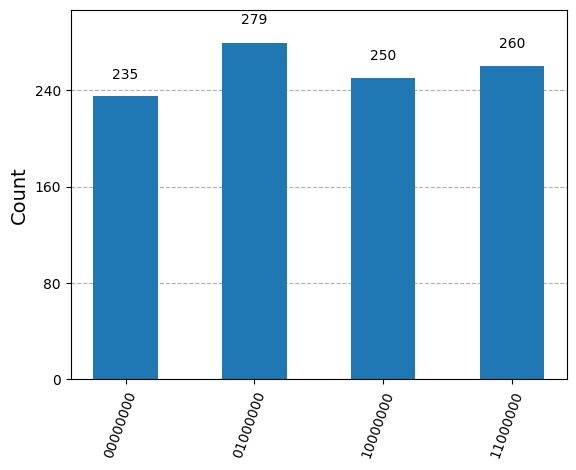

In [39]:
# Importing standard Qiskit libraries
from qiskit import transpile
from qiskit_aer import Aer, AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import SwapGate

a, N = 7, 15
q_circ = OrderFindingCircuit(a, N)
simulator = Aer.get_backend("qasm_simulator")
circuit = transpile(q_circ, simulator)

result = simulator.run(circuit, memory=True).result()
counts = result.get_counts(circuit)
plot_histogram(counts)

In [43]:
import pandas as pd

n = 2 * bits_required(N)
rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**n)  # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)",
                 f"{decimal}/{2**n} = {phase:.2f}"])
# Print the rows in a table
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

            Register Output           Phase
0  00000000(bin) =   0(dec)    0/256 = 0.00
1  01000000(bin) =  64(dec)   64/256 = 0.25
2  10000000(bin) = 128(dec)  128/256 = 0.50
3  11000000(bin) = 192(dec)  192/256 = 0.75


In [46]:
from fractions import Fraction

rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append([phase,
                 f"{frac.numerator}/{frac.denominator}",
                 frac.denominator])
# Print as a table
headers=["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

   Phase Fraction  Guess for r
0   0.00      0/1            1
1   0.25      1/4            4
2   0.50      1/2            2
3   0.75      3/4            4


In [81]:
def qpe_amodN(a,N,writer=print):

    n = 2*bits_required(N)
    qc = OrderFindingCircuit(a,N)
    simulator = Aer.get_backend("qasm_simulator")
    circuit = transpile(q_circ, simulator)
    result = simulator.run(circuit, shots=1, memory=True).result()

    readings = result.get_memory()
    writer(f'Register reads: {readings[0]}')
    phase = int(readings[0], 2) / (2**n)
    writer(f'Phase: {phase}')
    return phase

In [98]:

def QOrderFinder(a, N, max_iter=10, debug=False):

    cout = print if debug else (lambda _: _)

    for attempt in range(1, max_iter+1):
        cout(f'\nattempt {attempt}...')

        phase = qpe_amodN(a,N, cout)
        frac = Fraction(phase).limit_denominator(N)
        r = frac.denominator
        cout(f'found order r = {r}')

        if phase != 0:
            guesses = [math.gcd(a**(r//2)-1, N), math.gcd(a**(r//2)+1, N)]
            cout(f'guessed factors {guesses}')

            for guess in guesses:
                if guess in range(2,N) and (N % guess == 0):
                    cout(f'*** done: {guess} factors {N} ***')
                    return r

    # if no order could be found
    return 1

    
QOrderFinder(7,15, debug=True);


attempt 1...
Register reads: 00000000
Phase: 0.0
found r = 1

attempt 2...
Register reads: 01000000
Phase: 0.25
found r = 4
guessed factors [3, 5]
*** done: 3 factors 15 ***


## Shor's Algorithm

Finally, we can implement Shor's algorithm (outlined at the beginning of this notebook).

In [108]:
import numpy as np

def shor(N: int, max_iter=10):

    def core(N):
        # choose random integer 1 < a < N
        a = np.random.randint(2, N)
    
        b = math.gcd(a, N)
    
        if b != 1:
            print(f'b = {b} factors {N}, returning ({b}, {N/b})')
            return (b, N//b)
    
        # quantum subroutine to find the order r of a
        r = QOrderFinder(a, N)
    
        # if r is odd
        if r % 2 != 0:
            # return None indicating to try algorithm again
            return None
    
        # we know one of these is a factor of N
        gs = [math.gcd(a**(r//2)-1, N), math.gcd(a**(r//2)+1, N)]
    
        for g in gs:
            if g > 1 and g < N:
                print(f'factor {g} found, returning ({g}, {N//g})')
                return (g, N/g)

            # return None indicating to try algorithm again
            return None

    for attempt in range(1, max_iter+1):
        print(f'attempt {attempt}/{max_iter}')
        result = core(N)
        if result != None:
            break

    return result

        
shor(15)

attempt 1/10
attempt 2/10
attempt 3/10
attempt 4/10
b = 3 factors 15, returning (3, 5.0)


(3, 5)

In [75]:
import math
from qiskit import QuantumCircuit, ClassicalRegister, AncillaRegister, QuantumRegister
from qiskit.circuit.library import MultiplierGate

def NumBitsRequired(n: int) -> int:
    return int( math.log(n,2) + 1 ) if n > 0 else 0


def IntToBitList(n: int, num_bits: int = None) -> list:
    nbits = NumBitsRequired(n)
    if num_bits != None: nbits = num_bits

    return [(n >> bit) & 1 for bit in range(nbits - 1, -1, -1)]


def c_mod_mult(qc, target_register, copy_register, bit_register, ctrl_qubit, a, N):
    """
    Appends to the quantum circuit qc the operation |y⟩ -> |a*y mod N⟩ (y ~ target_register)
    controlled by ctrl_qubit.
    """

    # input registers must be same size
    m = len(target_register)
    if m != len(copy_register) or m != len(bit_register):
        print('registers are of different sizes')
        raise ValueError(f'Registers are of different sizes ({len(target_register)}, {len(copy_register)}, {len(bit_register)})')
    
    a_bits = IntToBitList(a, m)

    # initialize bit_register
    # since each qbit in bit_register is initialized to |0⟩
    #     we simply flip each qbit so that it is equivalent to `a`
    for i,bit in enumerate(a_bits):
        if bit == 1:
            qc.x(bit_register[i])

    # since copy_register is initialized to |0⟩
    #     doing a CX with target_register as control will result in
    #     copy_register being a 'copy' of target_register
    qc.cx(target_register, copy_register)

    mult_gate = MultiplierGate(m,m,label=f'* {a}^({ctrl_qubit._register.name}_{ctrl_qubit._index} * 2^{len(ctrl_qubit._register) - ctrl_qubit._index - 1})')
    qc.append(mult_gate, bit_register[:] + copy_register[:] + target_register[:])

    # multiplication is done - now uncompute ancillas
    for i,bit in enumerate(a_bits):
        if bit == 1:
            qc.x(bit_register[i])
    
    return


def c_amodN(qc: QuantumCircuit, qr1, qr2, ar1, ar2, a: int, N: int, x: int = 1, wrap = True):
    """
    Returns a quantum gate/circuit that implements |x⟩|y⟩ -> |x⟩|a^x mod N⟩
    """
    print(f'Running c_amodN with a = {a}, x = {x}, N = {N}')

    n = len(qr1)
    m = len(qr2)

    for i in range(n):
        exponent = 2**i
        a_exp = pow(a, exponent, N) # = (a^exponent) mod N

        ctrl_q = qr1[i]
        c_mod_mult(qc, qr2, ar1, ar2, ctrl_q, a_exp, N)

        return
    
    return

In [76]:
from qiskit.circuit.library import QFT
from qiskit import ClassicalRegister, QuantumRegister

def funclog(msg: str, debug):
    if debug: print(msg)

def BuildPeriodFindingCircuit(a, N, eps=1e-1, debug=True):
    L =  NumBitsRequired(N) # number of bits needed to represent N
    # m = L + math.ceil( math.log(2 + 1/2/eps, 2) )
    m = L
    n = 2*m
    
    funclog(f'n={n}, m={m}', debug)

    qr1 = QuantumRegister(n, name='x')
    qr2 = QuantumRegister(m, name='ψ')
    ar1 = AncillaRegister(m, name='copy')
    ar2 = AncillaRegister(m, name='a_bits')
    # Classical register for storing measurements
    crr = ClassicalRegister(n, name='clr')

    # Create circuit and initialize second register to |1⟩
    circ = QuantumCircuit(qr1, qr2, ar1, ar2, crr)
    circ.x(qr2[-1])
    funclog('initialized circuit', debug)

    # apply Hadamard gate to first register
    funclog('applying Hadamard...', debug)
    circ.h(qr1)
    circ.barrier()

    
    # apply the Unitary operator to second register
    # --------------------------------------------------------
    funclog('applying U...', debug)
  
    # modexp_circ = c_amodN(a, N, m)
    # circ = circ.compose(modexp_circ)
    c_amodN(circ, qr1, qr2, ar1, ar2, a, N, m, wrap=False)
        
    # --------------------------------------------------------
    circ.barrier()

    #Apply inverse QFT to the first Register
    funclog('applying IQFT...', debug)
    circ.append(QFT(n, inverse=True), qr1)
    circ.barrier()
    
    #Measure the first register 
    funclog('measuring...', debug)
    circ.measure(qr1, crr)
    
    return circ, n, m

In [104]:
a, N = 7, 15

circ, n, m = BuildPeriodFindingCircuit(a, N)

#Execute the ciruit 
circ.draw(fold=-1)

n=8, m=4
initialized circuit
applying Hadamard...
applying U...
Running c_amodN with a = 7, x = 4, N = 15
applying IQFT...
measuring...


┌───┐ ░                                                ░ ┌───────┐ ░ ┌─┐                     
     x_0: ┤ H ├─░────────────────────────────────────────────────░─┤0      ├─░─┤M├─────────────────────
          ├───┤ ░                                                ░ │       │ ░ └╥┘┌─┐                  
     x_1: ┤ H ├─░────────────────────────────────────────────────░─┤1      ├─░──╫─┤M├──────────────────
          ├───┤ ░                                                ░ │       │ ░  ║ └╥┘┌─┐               
     x_2: ┤ H ├─░────────────────────────────────────────────────░─┤2      ├─░──╫──╫─┤M├───────────────
          ├───┤ ░                                                ░ │       │ ░  ║  ║ └╥┘┌─┐            
     x_3: ┤ H ├─░────────────────────────────────────────────────░─┤3      ├─░──╫──╫──╫─┤M├────────────
          ├───┤ ░                                                ░ │  IQFT │ ░  ║  ║  ║ └╥┘┌─┐         
     x_4: ┤ H ├─░────────────────────────────────────────────────░─┤4      ├─░──╫──╫──╫──╫─┤M├─────────
          ├───┤ ░                                                ░ │       │ ░  ║  ║  ║  ║ └╥┘┌─┐      
     x_5: ┤ H ├─░────────────────────────────────────────────────░─┤5      ├─░──╫──╫──╫──╫──╫─┤M├──────
          ├───┤ ░                                                ░ │       │ ░  ║  ║  ║  ║  ║ └╥┘┌─┐   
     x_6: ┤ H ├─░────────────────────────────────────────────────░─┤6      ├─░──╫──╫──╫──╫──╫──╫─┤M├───
          ├───┤ ░                                                ░ │       │ ░  ║  ║  ║  ║  ║  ║ └╥┘┌─┐
     x_7: ┤ H ├─░────────────────────────────────────────────────░─┤7      ├─░──╫──╫──╫──╫──╫──╫──╫─┤M├
          └───┘ ░                     ┌───────────────────┐      ░ └───────┘ ░  ║  ║  ║  ║  ║  ║  ║ └╥┘
     ψ_0: ──────░───■─────────────────┤8                  ├──────░───────────░──╫──╫──╫──╫──╫──╫──╫──╫─
                ░   │                 │                   │      ░           ░  ║  ║  ║  ║  ║  ║  ║  ║ 
     ψ_1: ──────░───┼────■────────────┤9                  ├──────░───────────░──╫──╫──╫──╫──╫──╫──╫──╫─
                ░   │    │            │                   │      ░           ░  ║  ║  ║  ║  ║  ║  ║  ║ 
     ψ_2: ──────░───┼────┼────■───────┤10                 ├──────░───────────░──╫──╫──╫──╫──╫──╫──╫──╫─
          ┌───┐ ░   │    │    │       │                   │      ░           ░  ║  ║  ║  ║  ║  ║  ║  ║ 
     ψ_3: ┤ X ├─░───┼────┼────┼────■──┤11                 ├──────░───────────░──╫──╫──╫──╫──╫──╫──╫──╫─
          └───┘ ░ ┌─┴─┐  │    │    │  │                   │      ░           ░  ║  ║  ║  ║  ║  ║  ║  ║ 
  copy_0: ──────░─┤ X ├──┼────┼────┼──┤4                  ├──────░───────────░──╫──╫──╫──╫──╫──╫──╫──╫─
                ░ └───┘┌─┴─┐  │    │  │                   │      ░           ░  ║  ║  ║  ║  ║  ║  ║  ║ 
  copy_1: ──────░──────┤ X ├──┼────┼──┤5                  ├──────░───────────░──╫──╫──╫──╫──╫──╫──╫──╫─
                ░      └───┘┌─┴─┐  │  │   * 7^(x_0 * 2^7) │      ░           ░  ║  ║  ║  ║  ║  ║  ║  ║ 
  copy_2: ──────░───────────┤ X ├──┼──┤6                  ├──────░───────────░──╫──╫──╫──╫──╫──╫──╫──╫─
                ░           └───┘┌─┴─┐│                   │      ░           ░  ║  ║  ║  ║  ║  ║  ║  ║ 
  copy_3: ──────░────────────────┤ X ├┤7                  ├──────░───────────░──╫──╫──╫──╫──╫──╫──╫──╫─
                ░                └───┘│                   │      ░           ░  ║  ║  ║  ║  ║  ║  ║  ║ 
a_bits_0: ──────░─────────────────────┤0                  ├──────░───────────░──╫──╫──╫──╫──╫──╫──╫──╫─
                ░ ┌───┐               │                   │┌───┐ ░           ░  ║  ║  ║  ║  ║  ║  ║  ║ 
a_bits_1: ──────░─┤ X ├───────────────┤1                  ├┤ X ├─░───────────░──╫──╫──╫──╫──╫──╫──╫──╫─
                ░ ├───┤               │                   │├───┤ ░           ░  ║  ║  ║  ║  ║  ║  ║  ║ 
a_bits_2: ──────░─┤ X ├───────────────┤2                  ├┤ X ├─░───────────░──╫──╫──╫──╫──╫──╫──╫──╫─
                ░ ├───┤               │                   

In [46]:
from qiskit import transpile
from qiskit.circuit.library import RealAmplitudes
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import Aer, AerSimulator
from qiskit_aer.primitives import SamplerV2

simulator = AerSimulator()
circuit = transpile(circ, simulator)

result = simulator.run(circuit, shots=10, memory=True).result()
# memory = result.get_memory()
# phase = int(memory[0],2)/(2**(n-1))
# memory, phase, ContinuedFraction(phase)
print(result)

Result(backend_name='aer_simulator', backend_version='0.16.4', qobj_id='', job_id='a6a5062c-37b5-4407-9a26-634c18aba802', success=True, results=[ExperimentResult(shots=10, success=True, meas_level=2, data=ExperimentResultData(), header=QobjExperimentHeader(creg_sizes=[], global_phase=0.0, memory_slots=0, n_qubits=25, name='circuit-316', qreg_sizes=[['N', 4], ['a', 3], ['m', 3], ['s', 3], ['l', 2], ['r', 2], ['c', 1], ['f', 1], ['R', 3], ['r-l', 3]], metadata={}), status=DONE, seed_simulator=3668494053, metadata={'num_bind_params': 1, 'runtime_parameter_bind': False, 'parallel_state_update': 8, 'parallel_shots': 1, 'batched_shots_optimization': False, 'remapped_qubits': False, 'active_input_qubits': [], 'device': 'CPU', 'time_taken': 1.25e-05, 'measure_sampling': False, 'num_clbits': 0, 'max_memory_mb': 8192, 'input_qubit_map': [], 'num_qubits': 0, 'method': 'stabilizer', 'required_memory_mb': 0}, time_taken=1.25e-05)], date=2025-03-26T11:23:01.923130, status=COMPLETED, header=None, met